In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Class Imbalance

The goal here is to tackle Class imbalance. There are multiple steps taken to achieve this
1. Additional Startupdetector Data was labeled with industy labels
2. Additional examples for classes with low number of examples where generated with generative AI (ChatGPT)
3. Some examples in classes with high number of examples where dropped.

In [2]:
# joining Startupdetector Data
# read in
sd_df = pd.read_csv('../data/04_class_imbalance/further_data/startups-sd_data_testing.csv')
ind_corr = pd.read_csv('../data/industry_label_merge_filled.csv')
# translate sd industry
sd_df = sd_df.merge(ind_corr[['unique_values', 'molecule']], 'left', left_on='industry_startupdetector', right_on='unique_values')
# drop unnecessary columns
sd_df = sd_df.drop(columns=['industry', 'industry_type_merge', 'unique_values'])
sd_df = sd_df.rename({"molecule": "industry"}, axis=1)
sd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   startup_ID                   1139 non-null   int64  
 1   description_startupdetector  1139 non-null   object 
 2   startup_description          0 non-null      float64
 3   industry_startupdetector     1139 non-null   object 
 4   industry                     1121 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 44.6+ KB


In [3]:
# save sd data with merged industry tags
sd_df.to_csv('../data/data_augmentation/additional_sd_data.csv', index=False)

cells that could not be labeled automatically where labeled by hand.

In [4]:
sd_df = pd.read_csv('../data/04_class_imbalance/further_data/additional_sd_data_filled.csv')
sd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   startup_ID                   1139 non-null   int64  
 1   description_startupdetector  1139 non-null   object 
 2   startup_description          0 non-null      float64
 3   industry_startupdetector     1139 non-null   object 
 4   industry                     1139 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 44.6+ KB


In [5]:
# reading in all previous data points
all_df = pd.read_csv('../data/00_baseline/raw_data.csv')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4246 entries, 0 to 4245
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   startup_ID                   4246 non-null   int64 
 1   description_startupdetector  592 non-null    object
 2   startup_description          4112 non-null   object
 3   industry                     4246 non-null   object
dtypes: int64(1), object(3)
memory usage: 132.8+ KB


In [6]:
# reorganize columns in new sd data to match previous dataframe
sd_df = sd_df.drop(columns=['industry_startupdetector'])

In [7]:
# append data to dataframe with previous datapoints
raw_data_with_sd = pd.concat([all_df, sd_df])
# ensure there are no duplicate startup_IDs
raw_data_with_sd = raw_data_with_sd.drop_duplicates(subset=['startup_ID'])

raw_data_with_sd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5343 entries, 0 to 1138
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   startup_ID                   5343 non-null   int64 
 1   description_startupdetector  1722 non-null   object
 2   startup_description          4072 non-null   object
 3   industry                     5343 non-null   object
dtypes: int64(1), object(3)
memory usage: 208.7+ KB


In [8]:
# save new dataframe
raw_data_with_sd.to_csv('../data/04_class_imbalance/further_data/raw_data_with_sd.csv', index=False)

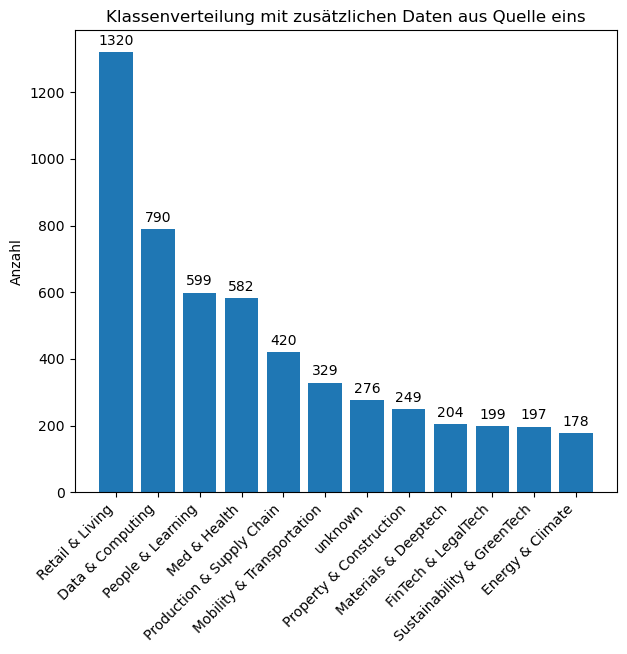

industry
Retail & Living               1320
Data & Computing               790
People & Learning              599
Med & Health                   582
Production & Supply Chain      420
Mobility & Transportation      329
unknown                        276
Property & Construction        249
Materials & Deeptech           204
FinTech & LegalTech            199
Sustainability & GreenTech     197
Energy & Climate               178
Name: count, dtype: int64


In [9]:
# show class balance after aditional Data
value_counts = raw_data_with_sd['industry'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(7, 6))
plt.bar_label(plt.bar(value_counts.index, value_counts.values), label_type='edge', padding=3)
plt.title("Klassenverteilung mit zusätzlichen Daten aus Quelle eins")
#plt.xlabel("Class")
plt.xticks(value_counts.index, rotation=45, ha='right')
plt.ylabel("Anzahl")
plt.show()

print(raw_data_with_sd['industry'].value_counts())

The additional Startupdetector Data did not bring any changes to the overall class imbalance.

On average each class should contain 445 Samples. The goal is to drop random examples from classes with over 445 examples and use generative AI to generate additional examples for the ones under 445. Because the augmentation could add in a new bias by falling back to very similar descriptions we will at max dubble the available datapoints

We will use OpenAIs ChatGPT for the text generation by feeding it existing examples first.

In [10]:
# read in generated examples
md = pd.read_csv('../data/04_class_imbalance/further_data/materials_deeptech_validated.csv')
sg = pd.read_csv('../data/04_class_imbalance/further_data/sustainability_greentech_validated.csv')
mt = pd.read_csv('../data/04_class_imbalance/further_data/mobility_transportation_validated.csv')
ps = pd.read_csv('../data/04_class_imbalance/further_data/production_supplychain_validated.csv')
pc = pd.read_csv('../data/04_class_imbalance/further_data/property_construction_validated.csv')
ec = pd.read_csv('../data/04_class_imbalance/further_data/energy_climate_validated.csv')
fl = pd.read_csv('../data/04_class_imbalance/further_data/fintech_legaltech_validated.csv')

# create dict with all datapoints
industry_augmented = {
    "Materials & Deeptech": md,
    "Sustainability & GreenTech": sg,
    "Mobility & Transportation": mt,
    "Production & Supply Chain": ps,
    "Property & Construction": pc,
    "Energy & Climate": ec,
    "FinTech & LegalTech": fl
}

In [11]:
# random drop examples from overrepresented classes
def drop_examples_from_subset(subset):
    # Drop randomly selected rows from the subset
    return subset.sample(n=445, random_state=42)

# add augmented_description column   
# get all industy names
industries = raw_data_with_sd['industry'].unique().tolist()
# create subsample per industry and downsample to 411 where necessary
ind_samples = []
for industry in industries:
    # create subsample with specific industy
    subset = raw_data_with_sd[raw_data_with_sd['industry'] == industry]
    # if sample has more than 411 entries run downsampling
    if len(subset) > 445:
        subset = drop_examples_from_subset(subset)
    elif industry == "unknown":
        subset = subset
    else:
        n_missing = 445 - len(subset)
        n_examples = len(subset)
        print(f'{industry}: length -> {n_examples} max missing -> {n_missing} --> {min(n_missing, n_examples)} will be added.')
        augmented = industry_augmented[industry].sample(n=min(n_missing, n_examples), random_state=42)
        subset = pd.concat([subset, augmented])
        
    ind_samples.append(subset)


Materials & Deeptech: length -> 204 max missing -> 241 --> 204 will be added.
Sustainability & GreenTech: length -> 197 max missing -> 248 --> 197 will be added.
Mobility & Transportation: length -> 329 max missing -> 116 --> 116 will be added.
Production & Supply Chain: length -> 420 max missing -> 25 --> 25 will be added.
Property & Construction: length -> 249 max missing -> 196 --> 196 will be added.
Energy & Climate: length -> 178 max missing -> 267 --> 178 will be added.
FinTech & LegalTech: length -> 199 max missing -> 246 --> 199 will be added.


In [12]:
full_augmented = pd.concat(ind_samples)
full_augmented.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4947 entries, 0 to 92
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   startup_ID                   3832 non-null   float64
 1   description_startupdetector  1153 non-null   object 
 2   startup_description          4123 non-null   object 
 3   industry                     4947 non-null   object 
dtypes: float64(1), object(3)
memory usage: 193.2+ KB


In [ ]:
# shuffle datafreame and save as csv
full_augmented = full_augmented.sample(frac = 1)
full_augmented.to_csv('../data/04_class_imbalance/raw_data.csv', index=False)

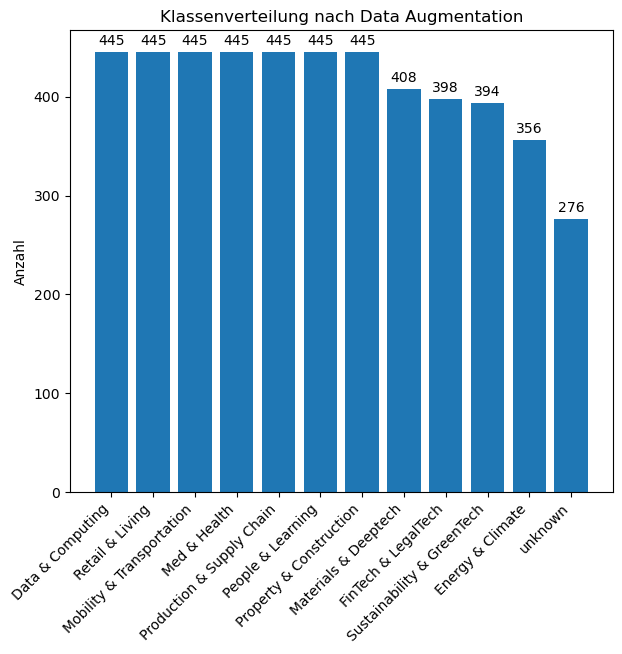

In [13]:
# show class balance after aditional Data
value_counts = full_augmented['industry'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(7, 6))
plt.bar_label(plt.bar(value_counts.index, value_counts.values), label_type='edge', padding=3)
plt.title("Klassenverteilung nach Data Augmentation")
#plt.xlabel("Class")
plt.xticks(value_counts.index, rotation=45, ha='right')
plt.ylabel("Anzahl")
plt.show()